In [1]:
import pandas as pd
import numpy as np
import holidays
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.dates as mdates
import pytz
import datetime
warnings.filterwarnings('ignore')

# 1. average model

## 1.1. load data

In [2]:
df = pd.read_csv('data\Yampa Historical Hourly Load-2019-2021(corrected).csv')
df

,Year,Month,Day,period,Total Gross Load,BTM Western Purchases,BTM Upper WCD Purchases,BTM Solar Purchases,BTM Craig Solar,Total Net Load Serve,Unnamed: 10,Unnamed: 11,Unnamed: 12,Source,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2019,1,1,1,93,3.08,0.38,0.00,0.00,89.95,NaN,NaN,Total Gross Load,YVEA Historical,NaN,NaN,NaN,NaN,NaN
1,2019,1,1,2,92,3.08,0.38,0.00,0.00,88.53,NaN,NaN,BTM Western Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
2,2019,1,1,3,91,3.08,0.38,0.00,0.00,87.75,NaN,NaN,BTM Upper WCD Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
3,2019,1,1,4,89,3.08,0.38,0.00,0.00,85.61,NaN,NaN,BTM Solar Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
4,2019,1,1,5,89,3.08,0.38,0.00,0.00,85.24,NaN,NaN,BTM Craig Solar,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22626,2021,7,31,20,54,2.13,0.35,0.12,2.63,48.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22627,2021,7,31,21,53,2.13,0.35,0.06,0.00,50.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22628,2021,7,31,22,50,2.13,0.35,0.00,0.00,47.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22629,2021,7,31,23,47,2.13,0.35,0.00,0.00,44.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['Year', 'Month ', 'Day', 'period', 'Total Gross Load',
       'BTM Western Purchases', 'BTM Upper WCD Purchases',
       'BTM Solar Purchases', 'BTM Craig Solar', ' Total Net Load Serve ',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Source', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

In [4]:
df.rename(columns={'Year':'year', 'Month ':'month', 'Day':'day', 'period':'time', 'Total Gross Load':'gross_load'}, inplace=True)
df.drop(columns=['BTM Western Purchases', 'BTM Upper WCD Purchases',
       'BTM Solar Purchases', 'BTM Craig Solar','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Source', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',' Total Net Load Serve ',], inplace=True)

In [5]:
df

,year,month,day,time,gross_load
0,2019,1,1,1,93
1,2019,1,1,2,92
2,2019,1,1,3,91
3,2019,1,1,4,89
4,2019,1,1,5,89
...,...,...,...,...,...
22626,2021,7,31,20,54
22627,2021,7,31,21,53
22628,2021,7,31,22,50
22629,2021,7,31,23,47


In [6]:
def time_convert(period):
    hour = (period - 1) % 24  # Convert period to 0-23 hour range
    return f'{hour:02d}:00:00'
# Create datetime column
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'].apply(time_convert))

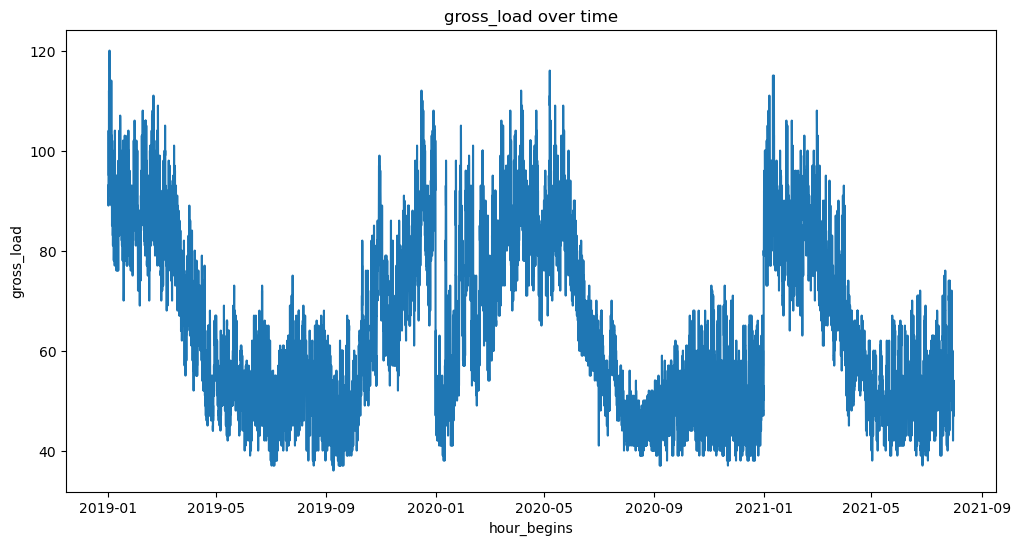

In [7]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

In [8]:

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the DataFrame
df['season'] = df['month'].apply(get_season)

Winter - Lower bound: 40.00, Upper bound: 106.00
Spring - Lower bound: 42.00, Upper bound: 102.00
Summer - Lower bound: 39.00, Upper bound: 79.00
Fall - Lower bound: 38.00, Upper bound: 87.00


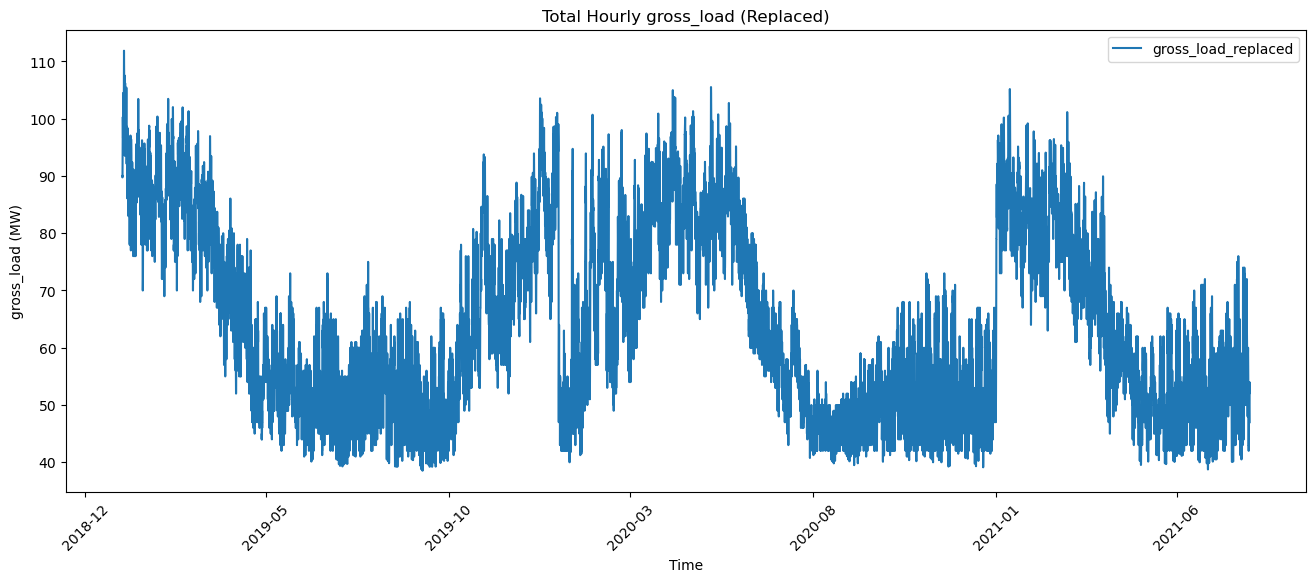

In [9]:
# Function to replace outliers within each season
def replace_outliers_with_avg_seasonal(df):
    df['gross_load_replaced'] = df['gross_load']
    for season in df['season'].unique():
        season_data = df[df['season'] == season]['gross_load']
        lower_bound = season_data.quantile(0.01)
        upper_bound = season_data.quantile(0.99)
        print(f'{season} - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}')
        
        outliers = (df['gross_load'] < lower_bound) | (df['gross_load'] > upper_bound) | (df['gross_load'] == 0) | (df['gross_load'] == np.nan) 
        
        # Remove continuous zeros or NaNs at the end
        while pd.isna(df.iloc[-1]['gross_load_replaced']) or df.iloc[-1]['gross_load_replaced'] == 0:
            df = df.iloc[:-1]

        for idx in df[outliers].index:
            if idx == 0 or idx == len(df) - 1:
                # directly drop the first and last value
                df.at[idx, 'gross_load_replaced'] = np.nan
                continue
            # Handle edge cases where previous or next value might be NaN or zero
            prev_idx = idx - 1
            next_idx = idx + 1
            while prev_idx >= 0 and (pd.isna(df.iloc[prev_idx]['gross_load_replaced']) or df.iloc[prev_idx]['gross_load_replaced'] == 0):
                prev_idx -= 1
            while next_idx < len(df) and (pd.isna(df.iloc[next_idx]['gross_load_replaced']) or df.iloc[next_idx]['gross_load_replaced'] == 0):
                next_idx += 1
            
            if prev_idx >= 0 and next_idx < len(df):
                prev_val = df.iloc[prev_idx]['gross_load_replaced']
                next_val = df.iloc[next_idx]['gross_load_replaced']
                df.at[idx, 'gross_load_replaced'] = (prev_val + next_val) / 2
            elif prev_idx >= 0:
                df.at[idx, 'gross_load_replaced'] = df.iloc[prev_idx]['gross_load_replaced']
            elif next_idx < len(df):
                df.at[idx, 'gross_load_replaced'] = df.iloc[next_idx]['gross_load_replaced']

    return df

df = replace_outliers_with_avg_seasonal(df)

plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'], label='gross_load_replaced')
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

In [10]:
df

,year,month,day,time,gross_load,hour_begins,season,gross_load_replaced
0,2019,1,1,1,93,2019-01-01 00:00:00,Winter,NaN
1,2019,1,1,2,92,2019-01-01 01:00:00,Winter,90.0000
2,2019,1,1,3,91,2019-01-01 02:00:00,Winter,89.7500
3,2019,1,1,4,89,2019-01-01 03:00:00,Winter,90.0000
4,2019,1,1,5,89,2019-01-01 04:00:00,Winter,91.0625
...,...,...,...,...,...,...,...,...
22626,2021,7,31,20,54,2021-07-31 19:00:00,Summer,54.0000
22627,2021,7,31,21,53,2021-07-31 20:00:00,Summer,53.0000
22628,2021,7,31,22,50,2021-07-31 21:00:00,Summer,50.0000
22629,2021,7,31,23,47,2021-07-31 22:00:00,Summer,47.0000



## 1.2.feature engineering

In [11]:
# calculate the daily average load
df['date'] = df['hour_begins'].dt.date
daily_gross_load = df.groupby('date')['gross_load_replaced'].mean().reset_index()
daily_high = df.groupby('date')['gross_load_replaced'].max().reset_index()
daily_low = df.groupby('date')['gross_load_replaced'].min().reset_index()
daily_std = df.groupby('date')['gross_load_replaced'].std().reset_index()

daily_gross_load['daily_high'] = daily_high['gross_load_replaced']
daily_gross_load['daily_low'] = daily_low['gross_load_replaced']
daily_gross_load['daily_std'] = daily_std['gross_load_replaced']
daily_gross_load.rename(columns = {'gross_load_replaced': 'daily_avg'}, inplace = True)

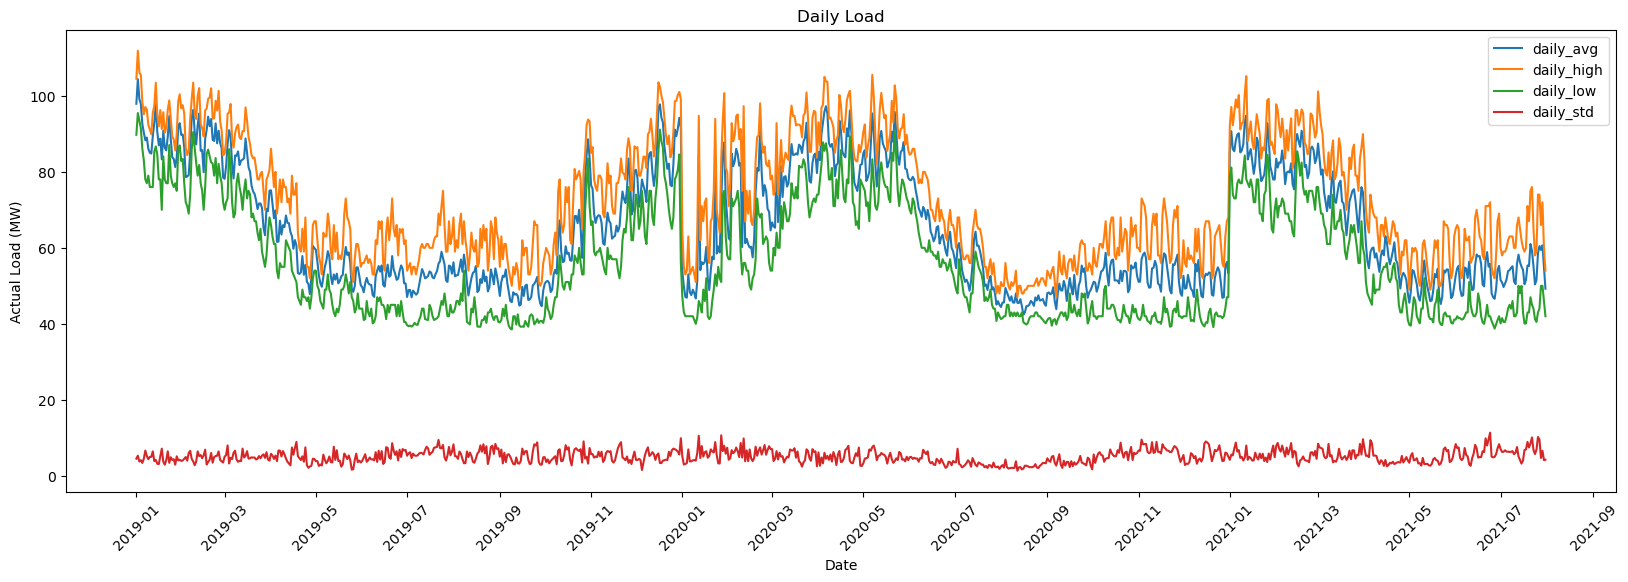

In [12]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_gross_load['date'], daily_gross_load['daily_avg'], l偶发凑热色偶分abel='daily_avg')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_high'], label='daily_high')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_low'], label='daily_low')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_std'], label='daily_std')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [13]:
daily_gross_load

,date,daily_avg,daily_high,daily_low,daily_std
0,2019-01-01,97.911848,104.516907,89.750000,4.532488
1,2019-01-02,104.392115,111.870929,95.456298,5.285624
2,2019-01-03,99.159446,106.209126,93.520676,3.769208
3,2019-01-04,97.909759,105.427118,91.492918,4.123749
4,2019-01-05,92.566819,98.380440,86.087036,3.393647
...,...,...,...,...,...
938,2021-07-27,60.458333,74.000000,44.000000,9.568877
939,2021-07-28,59.458333,66.000000,50.000000,4.708726
940,2021-07-29,60.666667,72.000000,50.000000,6.617938
941,2021-07-30,55.000000,60.000000,46.000000,4.128375


In [14]:
# day of the week, month, year, season vairables
daily_gross_load['date'] = pd.to_datetime(daily_gross_load['date'])
daily_gross_load['day'] = daily_gross_load['date'].dt.day
daily_gross_load['day_of_week'] = daily_gross_load['date'].dt.dayofweek
daily_gross_load['month'] = daily_gross_load['date'].dt.month
daily_gross_load['year'] = daily_gross_load['date'].dt.year
daily_gross_load['seasons'] = (daily_gross_load['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_gross_load['seasons'] = daily_gross_load['seasons'].map(seasons)

In [15]:
daily_gross_load['month_sin'] = np.sin((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['month_cos'] = np.cos((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['dow_sin'] = np.sin(daily_gross_load['day_of_week'] * (2. * np.pi / 7))
daily_gross_load['dow_cos'] = np.cos(daily_gross_load['day_of_week'] * (2. * np.pi / 7))

In [16]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_gross_load['holiday'] = daily_gross_load['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [17]:
daily_gross_load.drop(columns=['daily_high','daily_low', 'daily_std'], inplace=True)
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         943 non-null    datetime64[ns]
 1   daily_avg    943 non-null    float64       
 2   day          943 non-null    int32         
 3   day_of_week  943 non-null    int32         
 4   month        943 non-null    int32         
 5   year         943 non-null    int32         
 6   seasons      943 non-null    object        
 7   month_sin    943 non-null    float64       
 8   month_cos    943 non-null    float64       
 9   dow_sin      943 non-null    float64       
 10  dow_cos      943 non-null    float64       
 11  holiday      943 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1), object(1)
memory usage: 73.8+ KB


In [18]:
# print out the numerical and categorical features
numerical_features = daily_gross_load.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_gross_load.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_avg'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_gross_load = daily_gross_load[categorical_features + numerical_features + [target]]
daily_gross_load

Target variable: daily_avg
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date,day,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_avg
0,2019-01-01,1,1,1,2019,Winter,1,0.000000e+00,1.0,0.781831,0.623490,97.911848
1,2019-01-02,2,2,1,2019,Winter,0,0.000000e+00,1.0,0.974928,-0.222521,104.392115
2,2019-01-03,3,3,1,2019,Winter,0,0.000000e+00,1.0,0.433884,-0.900969,99.159446
3,2019-01-04,4,4,1,2019,Winter,0,0.000000e+00,1.0,-0.433884,-0.900969,97.909759
4,2019-01-05,5,5,1,2019,Winter,0,0.000000e+00,1.0,-0.974928,-0.222521,92.566819
...,...,...,...,...,...,...,...,...,...,...,...,...
938,2021-07-27,27,1,7,2021,Summer,0,1.224647e-16,-1.0,0.781831,0.623490,60.458333
939,2021-07-28,28,2,7,2021,Summer,0,1.224647e-16,-1.0,0.974928,-0.222521,59.458333
940,2021-07-29,29,3,7,2021,Summer,0,1.224647e-16,-1.0,0.433884,-0.900969,60.666667
941,2021-07-30,30,4,7,2021,Summer,0,1.224647e-16,-1.0,-0.433884,-0.900969,55.000000


In [19]:
daily_gross_load.columns

Index(['date', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'daily_avg'],
      dtype='object')

##  1.3. scaling and encoding

In [20]:
# encoding the categorical features - season only at the second column of values
daily_gross_load = pd.get_dummies(daily_gross_load, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_gross_load.columns:
    if daily_gross_load[col].dtype == 'bool':
        daily_gross_load[col] = daily_gross_load[col].astype(int)
# place the target variable at the last column
daily_gross_load = daily_gross_load[[c for c in daily_gross_load if c not in ['daily_avg']] + ['daily_avg']]

In [21]:
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2019-01-01,1,1,1,2019,1,0.000000e+00,1.0,0.781831,0.623490,0,0,1,97.911848
1,2019-01-02,2,2,1,2019,0,0.000000e+00,1.0,0.974928,-0.222521,0,0,1,104.392115
2,2019-01-03,3,3,1,2019,0,0.000000e+00,1.0,0.433884,-0.900969,0,0,1,99.159446
3,2019-01-04,4,4,1,2019,0,0.000000e+00,1.0,-0.433884,-0.900969,0,0,1,97.909759
4,2019-01-05,5,5,1,2019,0,0.000000e+00,1.0,-0.974928,-0.222521,0,0,1,92.566819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2021-07-27,27,1,7,2021,0,1.224647e-16,-1.0,0.781831,0.623490,0,1,0,60.458333
939,2021-07-28,28,2,7,2021,0,1.224647e-16,-1.0,0.974928,-0.222521,0,1,0,59.458333
940,2021-07-29,29,3,7,2021,0,1.224647e-16,-1.0,0.433884,-0.900969,0,1,0,60.666667
941,2021-07-30,30,4,7,2021,0,1.224647e-16,-1.0,-0.433884,-0.900969,0,1,0,55.000000


In [22]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_gross_load.iloc[:, 1:] = scaler.fit_transform(daily_gross_load.iloc[:, 1:])
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2019-01-01,0.000000,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0,0,1,0.895435
1,2019-01-02,0.033333,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0,0,1,1.000000
2,2019-01-03,0.066667,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0,0,1,0.915566
3,2019-01-04,0.100000,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0,0,1,0.895401
4,2019-01-05,0.133333,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0,0,1,0.809188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2021-07-27,0.866667,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0,1,0,0.291089
939,2021-07-28,0.900000,0.333333,0.545455,1.0,0,0.5,0.0,1.000000,3.568959e-01,0,1,0,0.274954
940,2021-07-29,0.933333,0.500000,0.545455,1.0,0,0.5,0.0,0.722521,5.551115e-17,0,1,0,0.294451
941,2021-07-30,0.966667,0.666667,0.545455,1.0,0,0.5,0.0,0.277479,0.000000e+00,0,1,0,0.203014


In [23]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_gross_load['daily_avg']
daily_gross_load.drop(columns='daily_avg', inplace=True)
daily_gross_load['daily_avg'] = gross_load_replaced
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2019-01-01,0.000000,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0,0,1,0.895435
1,2019-01-02,0.033333,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0,0,1,1.000000
2,2019-01-03,0.066667,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0,0,1,0.915566
3,2019-01-04,0.100000,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0,0,1,0.895401
4,2019-01-05,0.133333,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0,0,1,0.809188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2021-07-27,0.866667,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0,1,0,0.291089
939,2021-07-28,0.900000,0.333333,0.545455,1.0,0,0.5,0.0,1.000000,3.568959e-01,0,1,0,0.274954
940,2021-07-29,0.933333,0.500000,0.545455,1.0,0,0.5,0.0,0.722521,5.551115e-17,0,1,0,0.294451
941,2021-07-30,0.966667,0.666667,0.545455,1.0,0,0.5,0.0,0.277479,0.000000e+00,0,1,0,0.203014


In [25]:
daily_gross_load = daily_gross_load.dropna()
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            943 non-null    datetime64[ns]
 1   day             943 non-null    float64       
 2   day_of_week     943 non-null    float64       
 3   month           943 non-null    float64       
 4   year            943 non-null    float64       
 5   holiday         943 non-null    int64         
 6   month_sin       943 non-null    float64       
 7   month_cos       943 non-null    float64       
 8   dow_sin         943 non-null    float64       
 9   dow_cos         943 non-null    float64       
 10  seasons_Spring  943 non-null    int32         
 11  seasons_Summer  943 non-null    int32         
 12  seasons_Winter  943 non-null    int32         
 13  daily_avg       943 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int32(3), int64(1)
memor

## 1.4. dividing the data into training and testing

In [26]:
years_of_data = len(daily_gross_load) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_gross_load.shape[0]}')

Total years of data: 2.5835616438356164
Total number of days for training: 943


In [27]:
daily_gross_load = daily_gross_load.sort_values(by='date')
values = daily_gross_load.drop(columns='date').values
dates = daily_gross_load['date']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2019-01-01 00:00:00
max: 2020-10-21 00:00:00
length of in sample data: 660

min: 2020-10-22 00:00:00
max: 2021-07-31 00:00:00
length of out of sample data: 283


In [28]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(660, 1, 12) (660,) (283, 1, 12) (283,)


## 1.5. fitting the model

In [75]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=300, batch_size=70, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/300
10/10 - 1s - 88ms/step - loss: 0.3655 - mae: 0.3631 - mape: 145379.8750 - mse: 0.1948 - val_loss: 0.2993 - val_mae: 0.2970 - val_mape: 91.2252 - val_mse: 0.1397 - learning_rate: 5.0000e-04
Epoch 2/300
10/10 - 0s - 3ms/step - loss: 0.3005 - mae: 0.2981 - mape: 93277.5781 - mse: 0.1461 - val_loss: 0.2336 - val_mae: 0.2312 - val_mape: 64.5419 - val_mse: 0.1005 - learning_rate: 5.0000e-04
Epoch 3/300
10/10 - 0s - 3ms/step - loss: 0.2576 - mae: 0.2552 - mape: 229707.9219 - mse: 0.1135 - val_loss: 0.1959 - val_mae: 0.1935 - val_mape: 59.2655 - val_mse: 0.0750 - learning_rate: 5.0000e-04
Epoch 4/300
10/10 - 0s - 3ms/step - loss: 0.2297 - mae: 0.2273 - mape: 270538.5312 - mse: 0.0892 - val_loss: 0.1804 - val_mae: 0.1780 - val_mape: 64.7204 - val_mse: 0.0609 - learning_rate: 5.0000e-04
Epoch 5/300
10/10 - 0s - 3ms/step - loss: 0.2149 - mae: 0.2125 - mape: 378931.9688 - mse: 0.0760 - val_loss: 0.1777 - val_mae: 0.1753 - val_mape: 73.5944 - val_mse: 0.0537 - learning_rate: 5.0000e-04


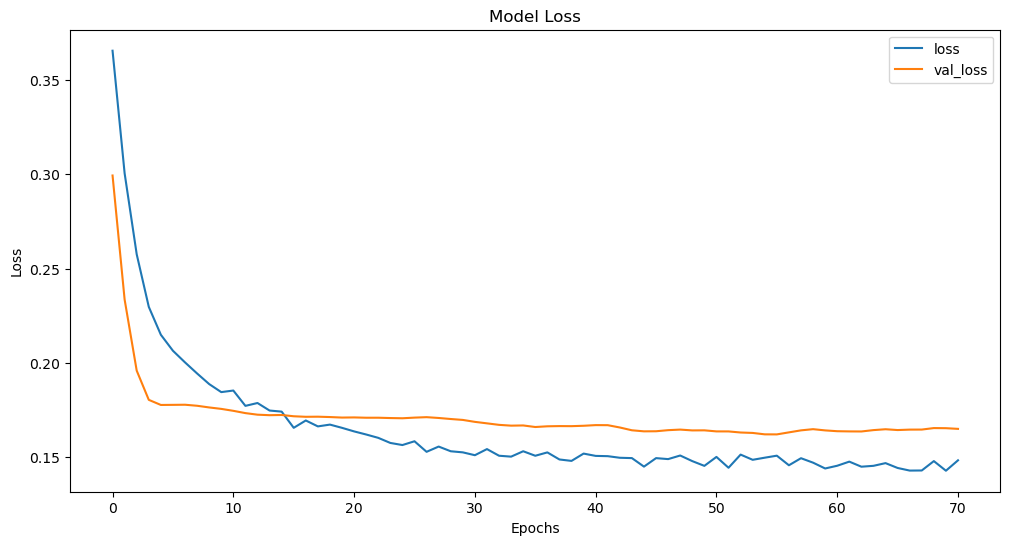

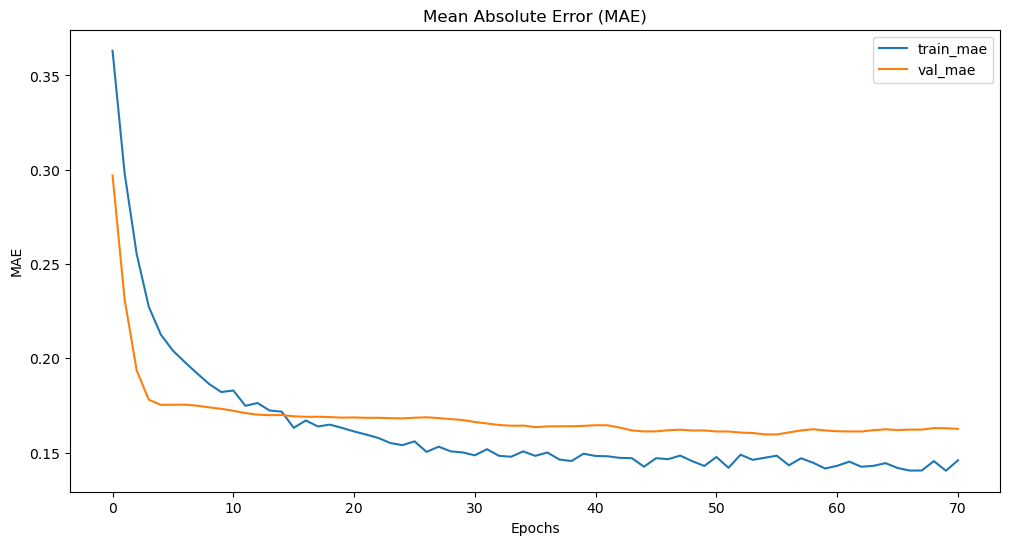

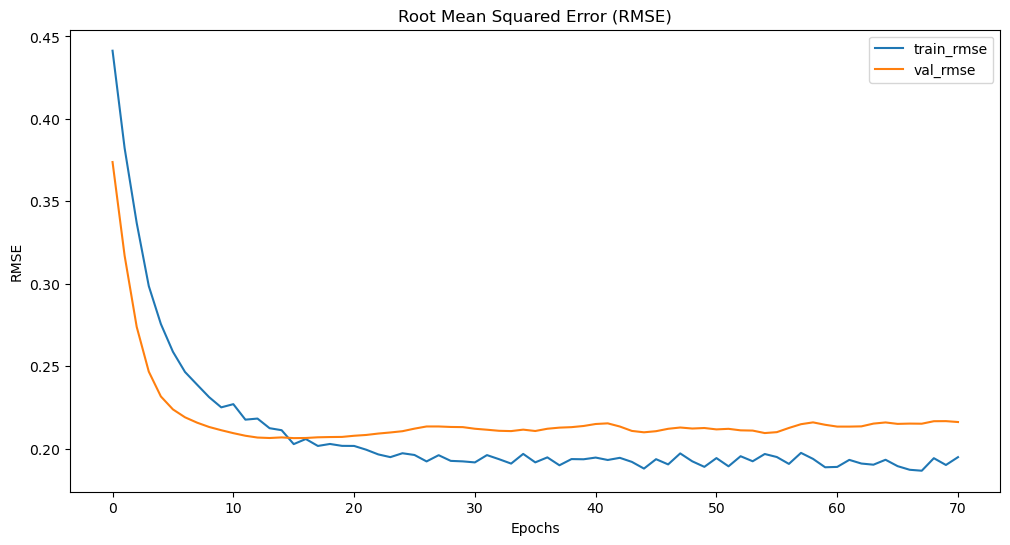

In [76]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [77]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
Train RMSE: 11.234
Train MAE: 8.478
Train MAPE: 13.194%

Test RMSE: 13.019
Test MAE: 9.891
Test MAPE: 17.823%


## 1.6. prediction plot

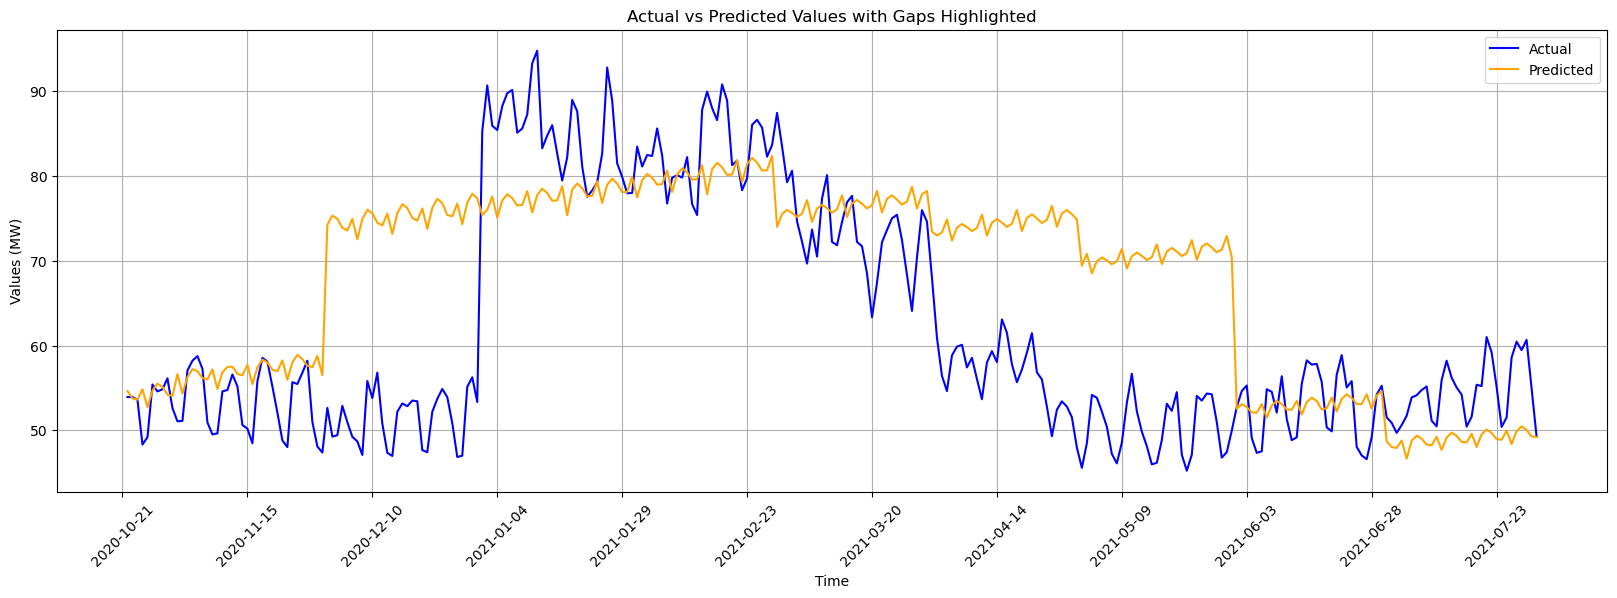

Gaps in data:


In [78]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")

# 2. sumup model

## 2.1. load data

In [246]:
df = pd.read_csv('data\Yampa Historical Hourly Load-2019-2021(corrected).csv')
df

,Year,Month,Day,period,Total Gross Load,BTM Western Purchases,BTM Upper WCD Purchases,BTM Solar Purchases,BTM Craig Solar,Total Net Load Serve,Unnamed: 10,Unnamed: 11,Unnamed: 12,Source,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2019,1,1,1,93,3.08,0.38,0.00,0.00,89.95,NaN,NaN,Total Gross Load,YVEA Historical,NaN,NaN,NaN,NaN,NaN
1,2019,1,1,2,92,3.08,0.38,0.00,0.00,88.53,NaN,NaN,BTM Western Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
2,2019,1,1,3,91,3.08,0.38,0.00,0.00,87.75,NaN,NaN,BTM Upper WCD Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
3,2019,1,1,4,89,3.08,0.38,0.00,0.00,85.61,NaN,NaN,BTM Solar Purchases,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
4,2019,1,1,5,89,3.08,0.38,0.00,0.00,85.24,NaN,NaN,BTM Craig Solar,Hourly estimated based on monthly/annual energy,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22626,2021,7,31,20,54,2.13,0.35,0.12,2.63,48.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22627,2021,7,31,21,53,2.13,0.35,0.06,0.00,50.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22628,2021,7,31,22,50,2.13,0.35,0.00,0.00,47.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22629,2021,7,31,23,47,2.13,0.35,0.00,0.00,44.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
df.columns

Index(['Year', 'Month ', 'Day', 'period', 'Total Gross Load',
       'BTM Western Purchases', 'BTM Upper WCD Purchases',
       'BTM Solar Purchases', 'BTM Craig Solar', ' Total Net Load Serve ',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Source', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

In [248]:
df.rename(columns={'Year':'year', 'Month ':'month', 'Day':'day', 'period':'time', 'Total Gross Load':'gross_load'}, inplace=True)
df.drop(columns=['BTM Western Purchases', 'BTM Upper WCD Purchases',
       'BTM Solar Purchases', 'BTM Craig Solar','Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Source', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',' Total Net Load Serve ',], inplace=True)

In [249]:
df

,year,month,day,time,gross_load
0,2019,1,1,1,93
1,2019,1,1,2,92
2,2019,1,1,3,91
3,2019,1,1,4,89
4,2019,1,1,5,89
...,...,...,...,...,...
22626,2021,7,31,20,54
22627,2021,7,31,21,53
22628,2021,7,31,22,50
22629,2021,7,31,23,47


In [250]:
def time_convert(period):
    hour = (period - 1) % 24  # Convert period to 0-23 hour range
    return f'{hour:02d}:00:00'
# Create datetime column
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'].apply(time_convert))

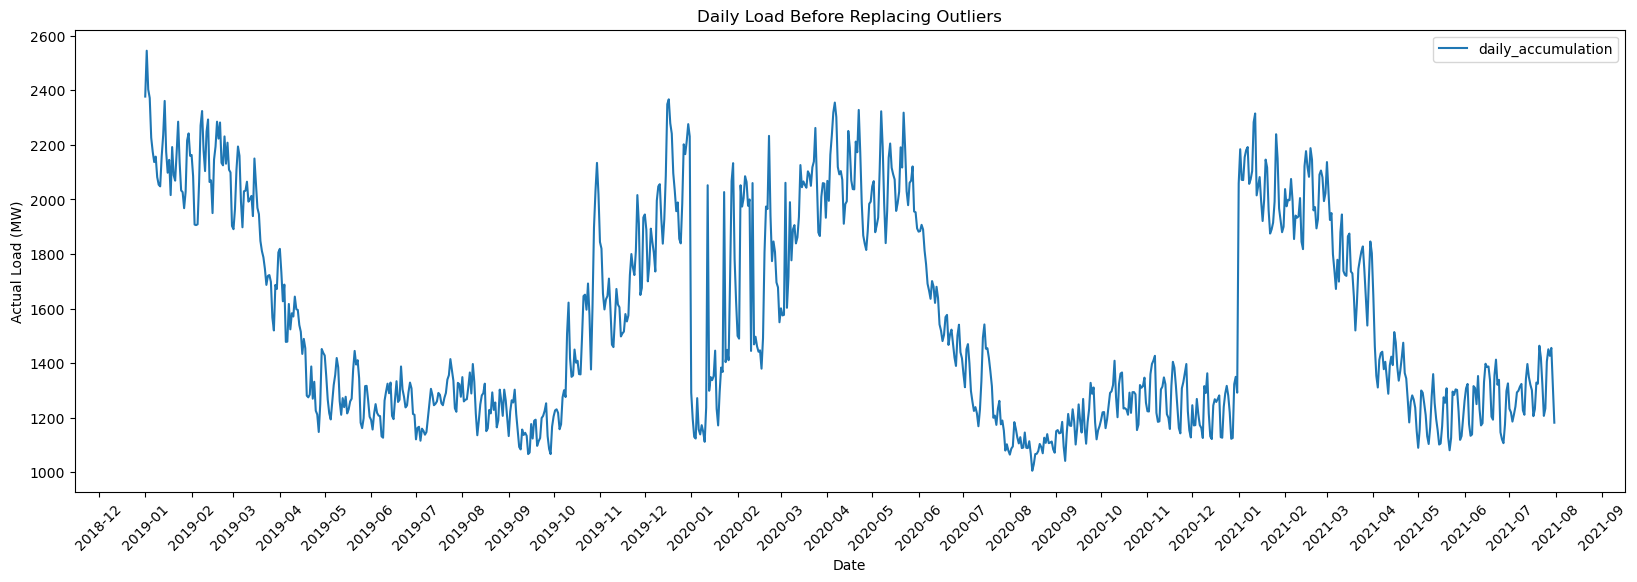

In [251]:
# calculate the daily accumulation of the load (gross_load_replaced)
df['date_begins'] = df['hour_begins'].dt.date
daily_accumulation_ = df.groupby('date_begins')['gross_load'].sum().reset_index()
daily_accumulation_.rename(columns = {'gross_load': 'daily_accumulation'}, inplace = True)
daily_accumulation_

import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_accumulation_['date_begins'], daily_accumulation_['daily_accumulation'], label='daily_accumulation')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load Before Replacing Outliers')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [252]:

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the DataFrame
df['season'] = df['month'].apply(get_season)

Winter - Lower bound: 40.00, Upper bound: 106.00
Number of outliers in Winter: 316

Spring - Lower bound: 42.00, Upper bound: 102.00
Number of outliers in Spring: 987

Summer - Lower bound: 39.00, Upper bound: 79.00
Number of outliers in Summer: 5604

Fall - Lower bound: 38.00, Upper bound: 87.00
Number of outliers in Fall: 2867



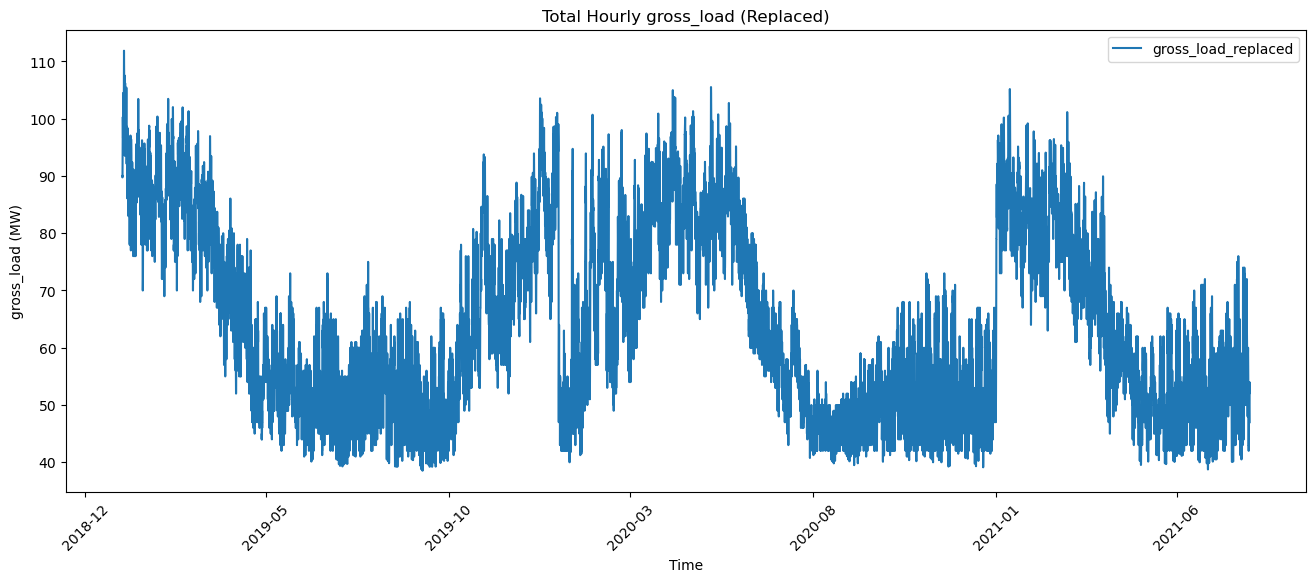

In [86]:
# Function to replace outliers within each season
def replace_outliers_with_avg_seasonal(df):
    df['gross_load_replaced'] = df['gross_load']
    for season in df['season'].unique():
        season_data = df[df['season'] == season]['gross_load']
        lower_bound = season_data.quantile(0.01)
        upper_bound = season_data.quantile(0.99)
        print(f'{season} - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}')
        
        outliers = (df['gross_load'] < lower_bound) | (df['gross_load'] > upper_bound) | (df['gross_load'] == 0) | (df['gross_load'] == np.nan) 
        print(f'Number of outliers in {season}: {outliers.sum()}\n')
        # Remove continuous zeros or NaNs at the end
        while pd.isna(df.iloc[-1]['gross_load_replaced']) or df.iloc[-1]['gross_load_replaced'] == 0:
            df = df.iloc[:-1]

        for idx in df[outliers].index:
            if idx == 0 or idx == len(df) - 1:
                # directly drop the first and last value
                df.at[idx, 'gross_load_replaced'] = np.nan
                continue
            # Handle edge cases where previous or next value might be NaN or zero
            prev_idx = idx - 1
            next_idx = idx + 1
            while prev_idx >= 0 and (pd.isna(df.iloc[prev_idx]['gross_load_replaced']) or df.iloc[prev_idx]['gross_load_replaced'] == 0):
                prev_idx -= 1
            while next_idx < len(df) and (pd.isna(df.iloc[next_idx]['gross_load_replaced']) or df.iloc[next_idx]['gross_load_replaced'] == 0):
                next_idx += 1
            
            if prev_idx >= 0 and next_idx < len(df):
                prev_val = df.iloc[prev_idx]['gross_load_replaced']
                next_val = df.iloc[next_idx]['gross_load_replaced']
                df.at[idx, 'gross_load_replaced'] = (prev_val + next_val) / 2
            elif prev_idx >= 0:
                df.at[idx, 'gross_load_replaced'] = df.iloc[prev_idx]['gross_load_replaced']
            elif next_idx < len(df):
                df.at[idx, 'gross_load_replaced'] = df.iloc[next_idx]['gross_load_replaced']

    return df

df = replace_outliers_with_avg_seasonal(df)

plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'], label='gross_load_replaced')
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

In [87]:
# Count the number of hours per day
df['date_begins'] = df['hour_begins'].dt.date
count_per_day = df.groupby('date_begins').size().reset_index(name='counts')

# Filter dates with less than 24 hours of data
incomplete_days = count_per_day[count_per_day['counts'] < 24]['date_begins']
print(f'Length of incomplete days: {len(incomplete_days)}')
print("Incomplete days (less than 24 hours of data):")
for day in incomplete_days:
    print(day)
# Remove rows with incomplete days
df_filtered = df[~df['date_begins'].isin(incomplete_days)]
df_filtered

Length of incomplete days: 3
Incomplete days (less than 24 hours of data):
2019-03-14
2020-03-13
2021-03-14


,year,month,day,time,gross_load,hour_begins,date_begins,season,gross_load_replaced
0,2019,1,1,1,93,2019-01-01 00:00:00,2019-01-01,Winter,NaN
1,2019,1,1,2,92,2019-01-01 01:00:00,2019-01-01,Winter,90.0000
2,2019,1,1,3,91,2019-01-01 02:00:00,2019-01-01,Winter,89.7500
3,2019,1,1,4,89,2019-01-01 03:00:00,2019-01-01,Winter,90.0000
4,2019,1,1,5,89,2019-01-01 04:00:00,2019-01-01,Winter,91.0625
...,...,...,...,...,...,...,...,...,...
22626,2021,7,31,20,54,2021-07-31 19:00:00,2021-07-31,Summer,54.0000
22627,2021,7,31,21,53,2021-07-31 20:00:00,2021-07-31,Summer,53.0000
22628,2021,7,31,22,50,2021-07-31 21:00:00,2021-07-31,Summer,50.0000
22629,2021,7,31,23,47,2021-07-31 22:00:00,2021-07-31,Summer,47.0000


In [253]:
df_filtered = df_filtered.dropna()
# calculate the daily accumulation of the load (gross_load_replaced)
daily_accumulation = df_filtered.groupby('date_begins')['gross_load_replaced'].sum().reset_index()
daily_accumulation.rename(columns = {'gross_load_replaced': 'daily_accumulation'}, inplace = True)
daily_accumulation

,date_begins,daily_accumulation
0,2019-01-01,2251.972514
1,2019-01-02,2505.410755
2,2019-01-03,2379.826701
3,2019-01-04,2349.834220
4,2019-01-05,2221.603648
...,...,...
935,2021-07-27,1451.000000
936,2021-07-28,1427.000000
937,2021-07-29,1456.000000
938,2021-07-30,1320.000000


In [258]:
# calculate monthlly total load by each year
monthly_total = df_filtered.groupby(['year', 'month'])['gross_load_replaced'].sum().reset_index()
monthly_total.rename(columns = {'gross_load_replaced': 'monthly_total'}, inplace = True
)
monthly_total['monthly_total'] = monthly_total['monthly_total'] / 1000
monthly_total['month_begins'] = pd.to_datetime(monthly_total['year'].astype(str) + '-' + monthly_total['month'].astype(str) + '-01')
monthly_total

,year,month,monthly_total,month_begins
0,2019,1,66.795182,2019-01-01
1,2019,2,59.168835,2019-02-01
2,2019,3,56.403872,2019-03-01
3,2019,4,43.900555,2019-04-01
4,2019,5,40.050000,2019-05-01
5,2019,6,37.574000,2019-06-01
6,2019,7,38.894439,2019-07-01
7,2019,8,39.032199,2019-08-01
8,2019,9,34.968973,2019-09-01
9,2019,10,45.941659,2019-10-01


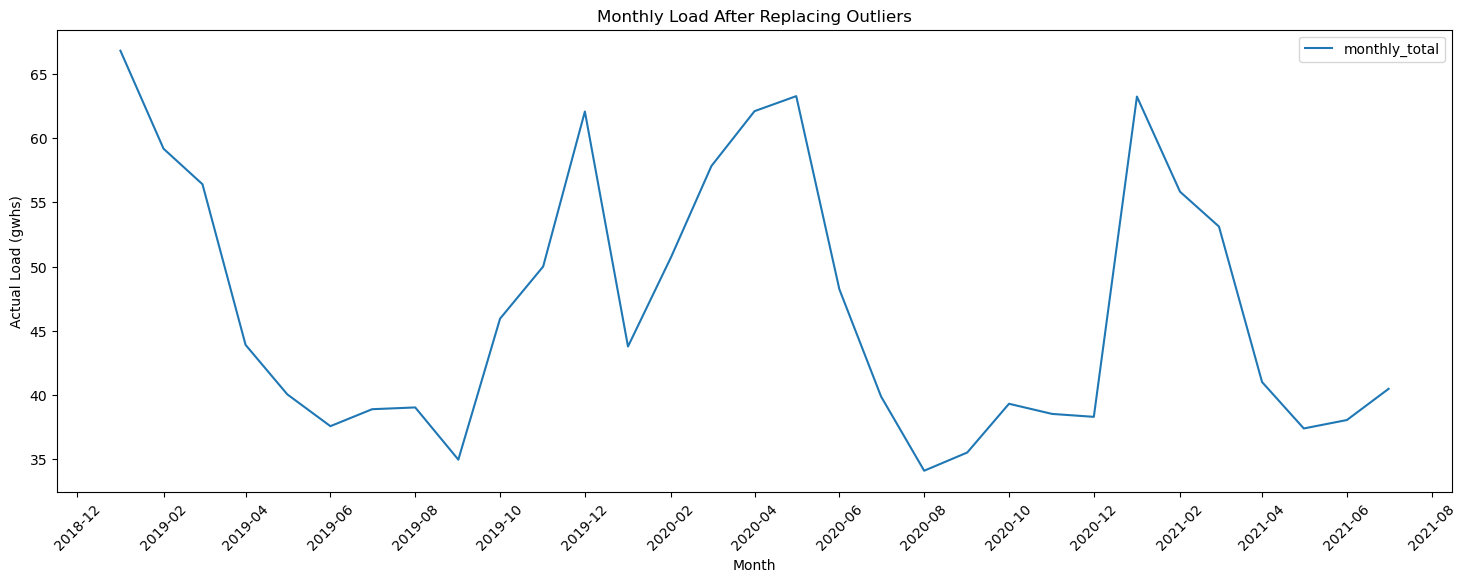

In [260]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(18, 6))
plt.plot(monthly_total['month_begins'], monthly_total['monthly_total'], label='monthly_total')
plt.xlabel('Month')
plt.ylabel('Actual Load (gwhs)')
plt.title('Monthly Load After Replacing Outliers')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

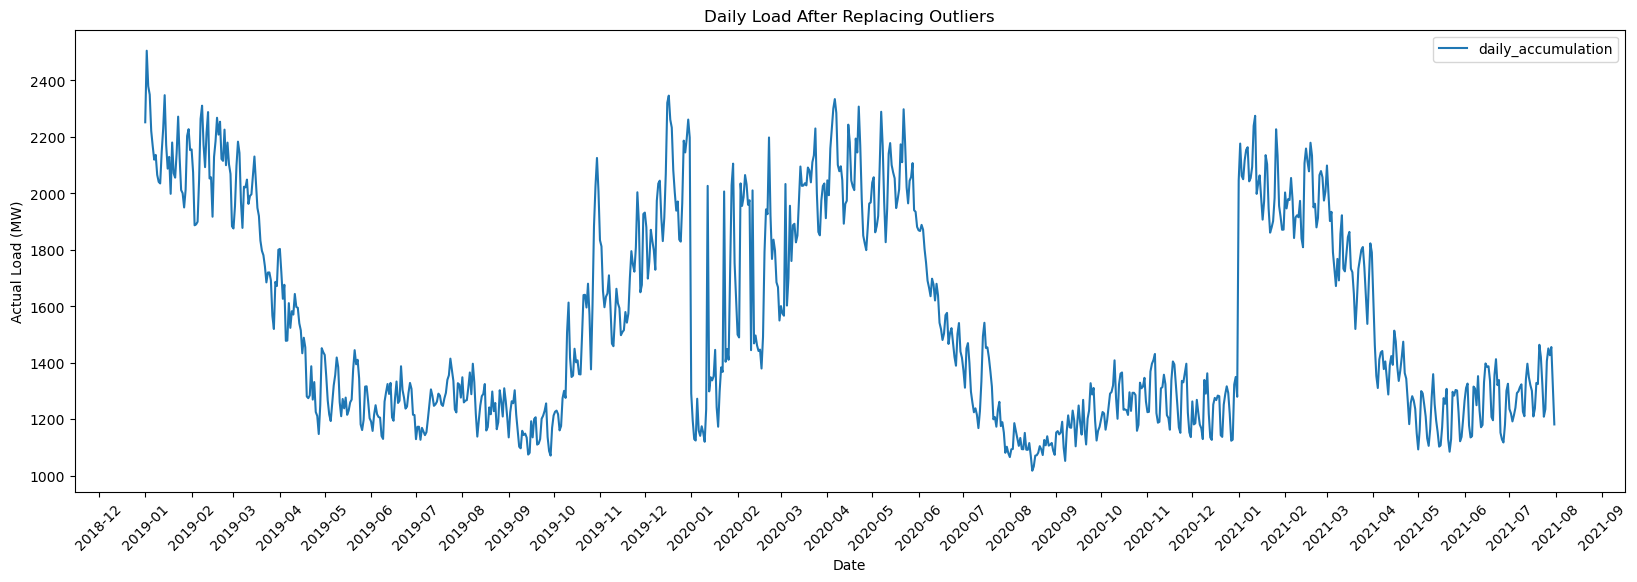

In [89]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_accumulation['date_begins'], daily_accumulation['daily_accumulation'], label='daily_accumulation')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load After Replacing Outliers')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

## 2.2. feature engineering

In [90]:
# day of the week, month, year, season vairables
daily_accumulation['date_begins'] = pd.to_datetime(daily_accumulation['date_begins'])
daily_accumulation['day'] = daily_accumulation['date_begins'].dt.day
daily_accumulation['day_of_week'] = daily_accumulation['date_begins'].dt.dayofweek
daily_accumulation['month'] = daily_accumulation['date_begins'].dt.month
daily_accumulation['year'] = daily_accumulation['date_begins'].dt.year
daily_accumulation['seasons'] = (daily_accumulation['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_accumulation['seasons'] = daily_accumulation['seasons'].map(seasons)

In [91]:
daily_accumulation['month_sin'] = np.sin((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['month_cos'] = np.cos((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['dow_sin'] = np.sin(daily_accumulation['day_of_week'] * (2. * np.pi / 7))
daily_accumulation['dow_cos'] = np.cos(daily_accumulation['day_of_week'] * (2. * np.pi / 7))

In [92]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_accumulation['holiday'] = daily_accumulation['date_begins'].apply(lambda x: 1 if x in us_holidays else 0)

In [93]:
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         940 non-null    datetime64[ns]
 1   daily_accumulation  940 non-null    float64       
 2   day                 940 non-null    int32         
 3   day_of_week         940 non-null    int32         
 4   month               940 non-null    int32         
 5   year                940 non-null    int32         
 6   seasons             940 non-null    object        
 7   month_sin           940 non-null    float64       
 8   month_cos           940 non-null    float64       
 9   dow_sin             940 non-null    float64       
 10  dow_cos             940 non-null    float64       
 11  holiday             940 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1), object(1)
memory usage: 73.6+ KB


In [94]:
daily_accumulation

,date_begins,daily_accumulation,day,day_of_week,month,year,seasons,month_sin,month_cos,dow_sin,dow_cos,holiday
0,2019-01-01,2251.972514,1,1,1,2019,Winter,0.000000e+00,1.0,0.781831,0.623490,1
1,2019-01-02,2505.410755,2,2,1,2019,Winter,0.000000e+00,1.0,0.974928,-0.222521,0
2,2019-01-03,2379.826701,3,3,1,2019,Winter,0.000000e+00,1.0,0.433884,-0.900969,0
3,2019-01-04,2349.834220,4,4,1,2019,Winter,0.000000e+00,1.0,-0.433884,-0.900969,0
4,2019-01-05,2221.603648,5,5,1,2019,Winter,0.000000e+00,1.0,-0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...
935,2021-07-27,1451.000000,27,1,7,2021,Summer,1.224647e-16,-1.0,0.781831,0.623490,0
936,2021-07-28,1427.000000,28,2,7,2021,Summer,1.224647e-16,-1.0,0.974928,-0.222521,0
937,2021-07-29,1456.000000,29,3,7,2021,Summer,1.224647e-16,-1.0,0.433884,-0.900969,0
938,2021-07-30,1320.000000,30,4,7,2021,Summer,1.224647e-16,-1.0,-0.433884,-0.900969,0


In [95]:
# print out the numerical and categorical features
numerical_features = daily_accumulation.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_accumulation.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_accumulation'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_accumulation = daily_accumulation[categorical_features + numerical_features + [target]]
daily_accumulation

Target variable: daily_accumulation
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date_begins', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date_begins,day,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_accumulation
0,2019-01-01,1,1,1,2019,Winter,1,0.000000e+00,1.0,0.781831,0.623490,2251.972514
1,2019-01-02,2,2,1,2019,Winter,0,0.000000e+00,1.0,0.974928,-0.222521,2505.410755
2,2019-01-03,3,3,1,2019,Winter,0,0.000000e+00,1.0,0.433884,-0.900969,2379.826701
3,2019-01-04,4,4,1,2019,Winter,0,0.000000e+00,1.0,-0.433884,-0.900969,2349.834220
4,2019-01-05,5,5,1,2019,Winter,0,0.000000e+00,1.0,-0.974928,-0.222521,2221.603648
...,...,...,...,...,...,...,...,...,...,...,...,...
935,2021-07-27,27,1,7,2021,Summer,0,1.224647e-16,-1.0,0.781831,0.623490,1451.000000
936,2021-07-28,28,2,7,2021,Summer,0,1.224647e-16,-1.0,0.974928,-0.222521,1427.000000
937,2021-07-29,29,3,7,2021,Summer,0,1.224647e-16,-1.0,0.433884,-0.900969,1456.000000
938,2021-07-30,30,4,7,2021,Summer,0,1.224647e-16,-1.0,-0.433884,-0.900969,1320.000000


In [96]:
daily_accumulation.columns

Index(['date_begins', 'day', 'day_of_week', 'month', 'year', 'seasons',
       'holiday', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
       'daily_accumulation'],
      dtype='object')

##  2.3. scaling and encoding

In [97]:
# encoding the categorical features - season only at the second column of values
daily_accumulation = pd.get_dummies(daily_accumulation, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_accumulation.columns:
    if daily_accumulation[col].dtype == 'bool':
        daily_accumulation[col] = daily_accumulation[col].astype(int)
# place the target variable at the last column
daily_accumulation = daily_accumulation[[c for c in daily_accumulation if c not in ['daily_accumulation']] + ['daily_accumulation']]

In [98]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_accumulation.iloc[:, 1:] = scaler.fit_transform(daily_accumulation.iloc[:, 1:])
daily_accumulation

,date_begins,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2019-01-01,0.000000,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0,0,1,0.829606
1,2019-01-02,0.033333,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0,0,1,1.000000
2,2019-01-03,0.066667,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0,0,1,0.915566
3,2019-01-04,0.100000,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0,0,1,0.895401
4,2019-01-05,0.133333,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0,0,1,0.809188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,2021-07-27,0.866667,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0,1,0,0.291089
936,2021-07-28,0.900000,0.333333,0.545455,1.0,0,0.5,0.0,1.000000,3.568959e-01,0,1,0,0.274954
937,2021-07-29,0.933333,0.500000,0.545455,1.0,0,0.5,0.0,0.722521,5.551115e-17,0,1,0,0.294451
938,2021-07-30,0.966667,0.666667,0.545455,1.0,0,0.5,0.0,0.277479,0.000000e+00,0,1,0,0.203014


In [99]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_accumulation['daily_accumulation']
daily_accumulation.drop(columns='daily_accumulation', inplace=True)
daily_accumulation['daily_accumulation'] = gross_load_replaced
daily_accumulation

,date_begins,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2019-01-01,0.000000,0.166667,0.000000,0.0,1,0.5,1.0,0.900969,8.019377e-01,0,0,1,0.829606
1,2019-01-02,0.033333,0.333333,0.000000,0.0,0,0.5,1.0,1.000000,3.568959e-01,0,0,1,1.000000
2,2019-01-03,0.066667,0.500000,0.000000,0.0,0,0.5,1.0,0.722521,5.551115e-17,0,0,1,0.915566
3,2019-01-04,0.100000,0.666667,0.000000,0.0,0,0.5,1.0,0.277479,0.000000e+00,0,0,1,0.895401
4,2019-01-05,0.133333,0.833333,0.000000,0.0,0,0.5,1.0,0.000000,3.568959e-01,0,0,1,0.809188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,2021-07-27,0.866667,0.166667,0.545455,1.0,0,0.5,0.0,0.900969,8.019377e-01,0,1,0,0.291089
936,2021-07-28,0.900000,0.333333,0.545455,1.0,0,0.5,0.0,1.000000,3.568959e-01,0,1,0,0.274954
937,2021-07-29,0.933333,0.500000,0.545455,1.0,0,0.5,0.0,0.722521,5.551115e-17,0,1,0,0.294451
938,2021-07-30,0.966667,0.666667,0.545455,1.0,0,0.5,0.0,0.277479,0.000000e+00,0,1,0,0.203014


In [100]:
daily_accumulation = daily_accumulation.dropna()
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         940 non-null    datetime64[ns]
 1   day                 940 non-null    float64       
 2   day_of_week         940 non-null    float64       
 3   month               940 non-null    float64       
 4   year                940 non-null    float64       
 5   holiday             940 non-null    int64         
 6   month_sin           940 non-null    float64       
 7   month_cos           940 non-null    float64       
 8   dow_sin             940 non-null    float64       
 9   dow_cos             940 non-null    float64       
 10  seasons_Spring      940 non-null    int32         
 11  seasons_Summer      940 non-null    int32         
 12  seasons_Winter      940 non-null    int32         
 13  daily_accumulation  940 non-null    float64       

## 2.4. dividing the data into training and testing

In [101]:
years_of_data = len(daily_accumulation) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_accumulation.shape[0]}')

Total years of data: 2.5753424657534247
Total number of days for training: 940


In [102]:
daily_accumulation = daily_accumulation.sort_values(by='date_begins')
values = daily_accumulation.drop(columns='date_begins').values
dates = daily_accumulation['date_begins']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2019-01-01 00:00:00
max: 2020-10-21 00:00:00
length of in sample data: 658

min: 2020-10-22 00:00:00
max: 2021-07-31 00:00:00
length of out of sample data: 282


In [103]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(658, 1, 12) (658,) (282, 1, 12) (282,)


## 2.5. fitting the model

In [239]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.35))
model.add(Dense(1,kernel_regularizer=l2(0.0001)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.0003
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=200, batch_size=50, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/200
14/14 - 1s - 63ms/step - loss: 0.3262 - mae: 0.3260 - mape: 158156.0312 - mse: 0.1746 - val_loss: 0.2392 - val_mae: 0.2390 - val_mape: 64.6946 - val_mse: 0.1072 - learning_rate: 3.0000e-04
Epoch 2/200
14/14 - 0s - 3ms/step - loss: 0.2909 - mae: 0.2907 - mape: 388261.0000 - mse: 0.1447 - val_loss: 0.2109 - val_mae: 0.2107 - val_mape: 61.8235 - val_mse: 0.0867 - learning_rate: 3.0000e-04
Epoch 3/200
14/14 - 0s - 2ms/step - loss: 0.2669 - mae: 0.2667 - mape: 528220.3750 - mse: 0.1237 - val_loss: 0.1938 - val_mae: 0.1936 - val_mape: 64.3948 - val_mse: 0.0730 - learning_rate: 3.0000e-04
Epoch 4/200
14/14 - 0s - 2ms/step - loss: 0.2520 - mae: 0.2518 - mape: 372191.0938 - mse: 0.1077 - val_loss: 0.1866 - val_mae: 0.1864 - val_mape: 69.3500 - val_mse: 0.0649 - learning_rate: 3.0000e-04
Epoch 5/200
14/14 - 0s - 2ms/step - loss: 0.2367 - mae: 0.2365 - mape: 480329.0938 - mse: 0.0937 - val_loss: 0.1835 - val_mae: 0.1833 - val_mape: 74.8110 - val_mse: 0.0595 - learning_rate: 3.0000e-04

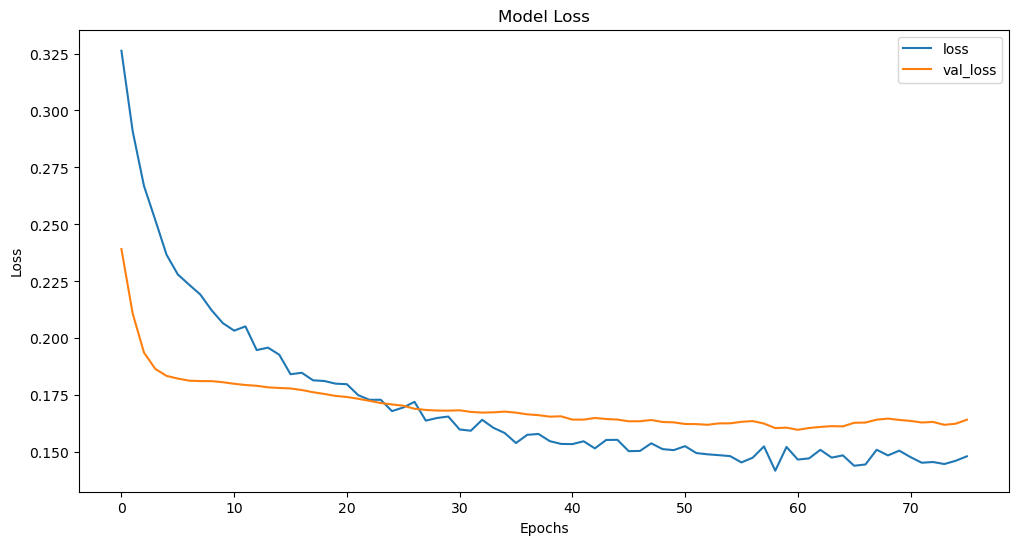

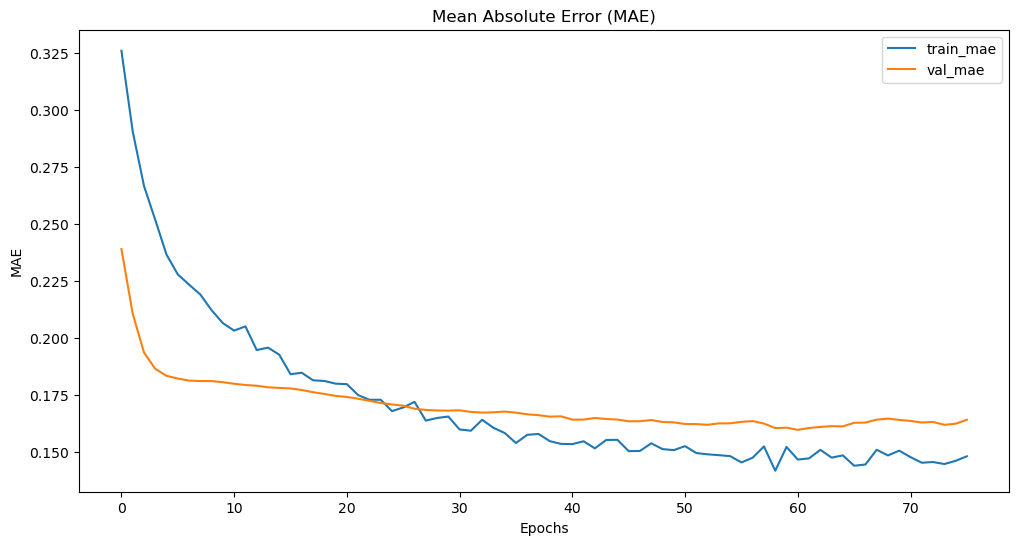

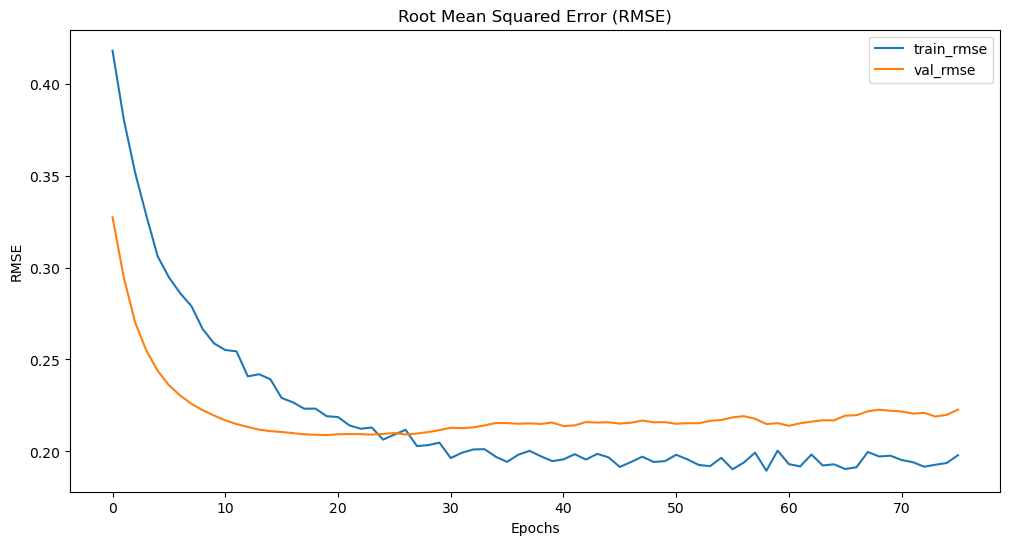

In [240]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [241]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
Train RMSE: 270.293
Train MAE: 206.889
Train MAPE: 13.308%

Test RMSE: 318.189
Test MAE: 237.439
Test MAPE: 17.953%


## 2.6. prediction plot

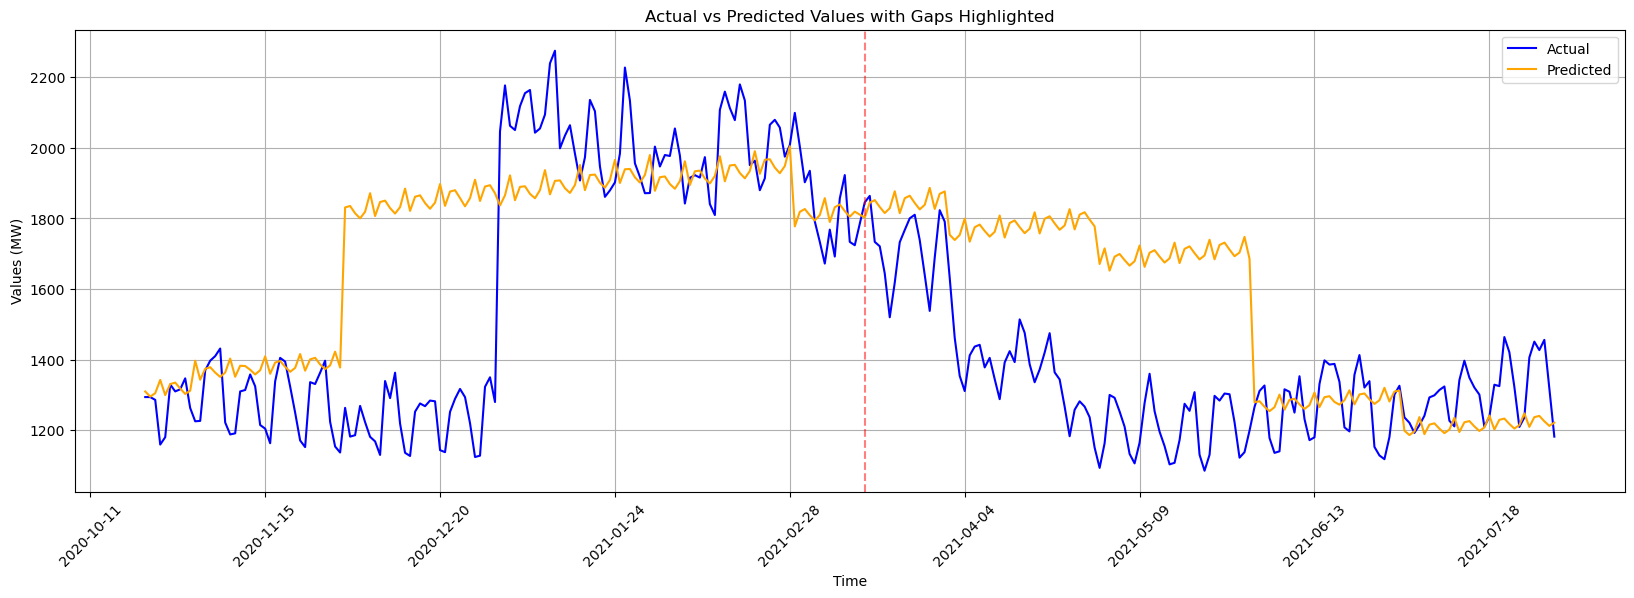

Gaps in data:
Gap Start: 2021-03-13
Gap ends at: 2021-03-15
Time Difference: 2.0 days



In [242]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=35))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")